# Analysis of readability of PR descriptions and acceptance time

## Imports and loading data

In [1]:
# Imports
import pandas as pd
import numpy as np
import scipy
import scipy.stats as stats
import json
import seaborn as sns
import matplotlib.pyplot as plt
# Plot settings for retina
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Create dataframe with PR data
def load_data() -> pd.DataFrame:
    f_name = 'raw_data.json'
    with open(f_name) as f:
        data = json.load(f)
        df = pd.json_normalize(data)
    cols = ['_id', 'text', 'textLen', 'closingTime', 'isMerged', 'FRE', 'FKG', 'DCS', 'PRDS']
    df['textLen'] = df['text'].str.len()
    return df.rename(columns = {
        'readability.daleChallScore': 'DCS',
        'readability.fleschKincaidGradeLevel': 'FKG',
        'readability.fleschReadingEase': 'FRE',
        'readability.pullRequestDomainScore': 'PRDS'
    })[cols]

In [3]:
df = load_data()
df

,_id,text,textLen,closingTime,isMerged,FRE,FKG,DCS,PRDS
0,5ed99bb1abc35e0772a1a254,fix unicode exceptions.\nThis fix PressLabs/bi...,61,25.0,True,33.575000,9.570000,13.703650,11.729900
1,5ed99bb1abc35e0772a1a256,Test transactions\nfixes #344,28,1027.0,True,6.390000,13.113333,14.311967,9.048633
2,5ed99bb1abc35e0772a1a258,Add drone publish image. And fix requirment de...,56,17.0,True,33.575000,9.570000,13.703650,11.729900
3,5ed99bb1abc35e0772a1a25a,Add secrets to drone.,21,7.0,True,97.025000,0.720000,11.729900,11.729900
4,5ed99bb1abc35e0772a1a25c,Secrets,7,17.0,True,36.620000,8.400000,19.476100,19.476100
...,...,...,...,...,...,...,...,...,...
2994,5ed99bb2abc35e0772a1b9b8,Add oclclient to prd environment,32,1248.0,True,66.400000,5.240000,13.358500,13.358500
2995,5ed99bb2abc35e0772a1b9ba,Removal of </img>\nRemoval of \</img\> because...,120,292.0,True,48.548571,11.704762,10.693338,8.437624
2996,5ed99bb2abc35e0772a1b9bc,Make usernames stick to avatar in navbar\nUser...,586,4.0,True,37.220000,18.005000,11.739125,9.765375
2997,5ed99bb2abc35e0772a1b9be,Make flags overlap category icon\nIt should do...,371,266.0,True,64.844194,11.916129,11.541035,9.248939


In [4]:
def remove_low_values(_df: pd.DataFrame) -> pd.DataFrame:
    low_text_len = _df['textLen'] < 50
    low_closing_time = _df['closingTime'] < 30
    return _df[~low_text_len & ~low_closing_time].reset_index(drop=True)

In [5]:
def remove_non_merged(_df: pd.DataFrame) -> pd.DataFrame:
    return _df[_df['isMerged']].reset_index(drop=True)

In [6]:
clean_df = remove_non_merged(remove_low_values(df))

In [7]:
clean_df.head()

,_id,text,textLen,closingTime,isMerged,FRE,FKG,DCS,PRDS
0,5ed99bb1abc35e0772a1a25e,Add zone tests.\nHere are just some tests for ...,72,8512.0,True,111.455476,-1.127143,9.507252,6.123681
1,5ed99bb1abc35e0772a1a276,Check if a cname exists when creating a policy...,63,2794.0,True,78.197955,3.718636,9.651118,8.215664
2,5ed99bb1abc35e0772a1a27c,Delete the record when reconcile policy record...,108,84.0,True,16.107500,14.987500,13.311975,11.338225
3,5ed99bb1abc35e0772a1a280,Zone admin sorting order and allow searching. ...,61,328.0,True,54.725000,6.620000,13.703650,11.729900
4,5ed99bb1abc35e0772a1a288,Add pt-heartbeat and fix podspec verification....,55,2971.0,True,21.996786,11.060714,12.832957,10.577243


In [8]:
clean_df.describe()

,textLen,closingTime,FRE,FKG,DCS,PRDS
count,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000
mean,219.205841,2507.923505,37.092654,12.871596,13.121277,9.852440
std,159.634602,3035.515340,28.505312,5.788220,2.462399,2.372736
min,50.000000,30.000000,-102.412857,-1.450000,5.617555,0.479467
25%,91.000000,214.000000,20.533162,8.969862,11.359373,8.340273
50%,174.000000,1238.500000,39.966080,11.717677,12.855122,9.676563
75%,308.750000,3926.750000,56.700000,15.763750,14.689144,11.100678
max,719.000000,13754.000000,116.145000,44.203725,20.170500,19.624900


In [9]:
def distribution_of_col(_df: pd.DataFrame, col: str, fname: str = None):
    plt.rcParams["figure.figsize"] = [16,5]
    sns.boxplot(orient="h", data=_df[col]).set_title(f"Distribution of {col}", fontsize=15)
    if fname:
        plt.savefig(f'figures/{fname}', bbox_inches='tight')
    plt.show()

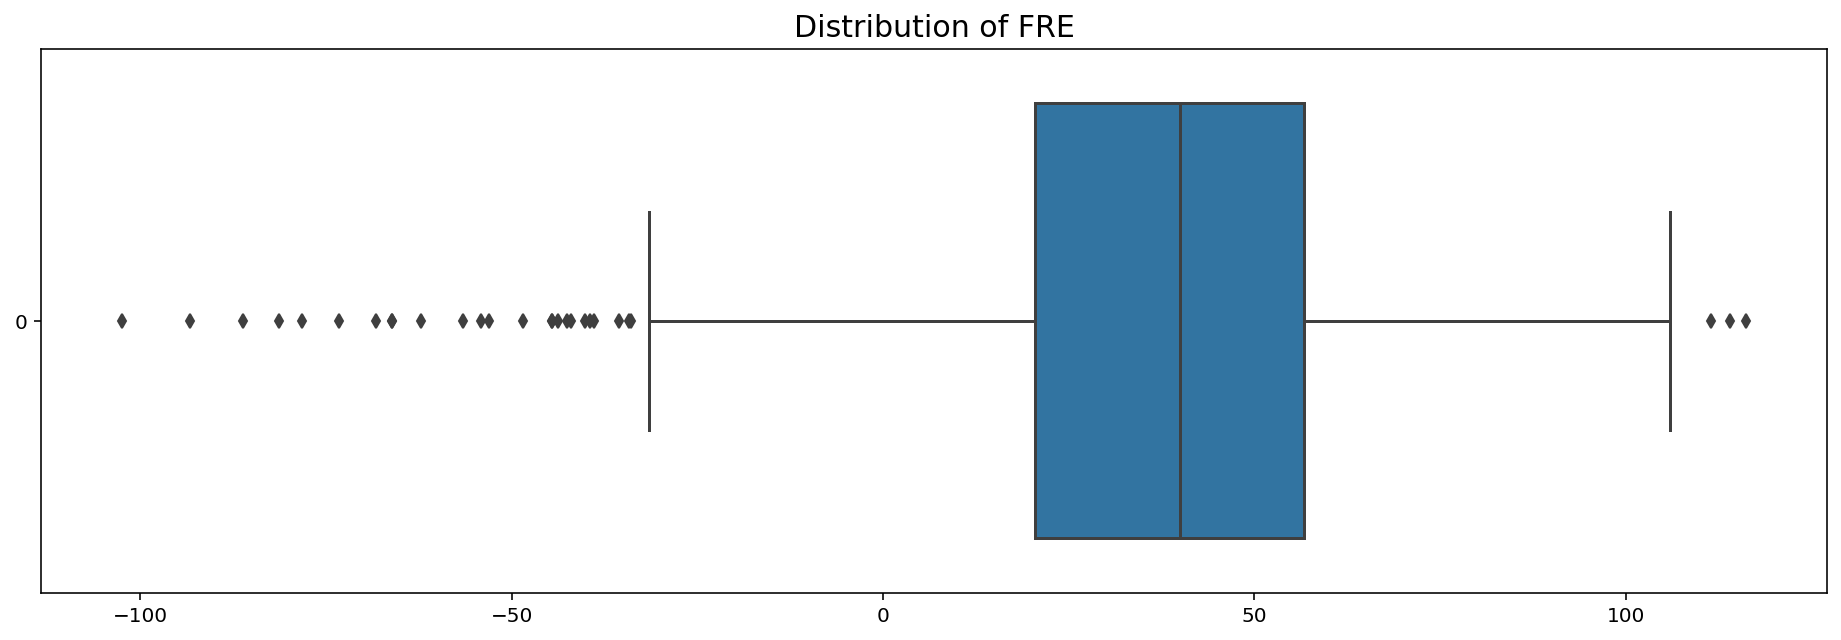

In [10]:
distribution_of_col(clean_df, 'FRE', 'fre-distribution.png')

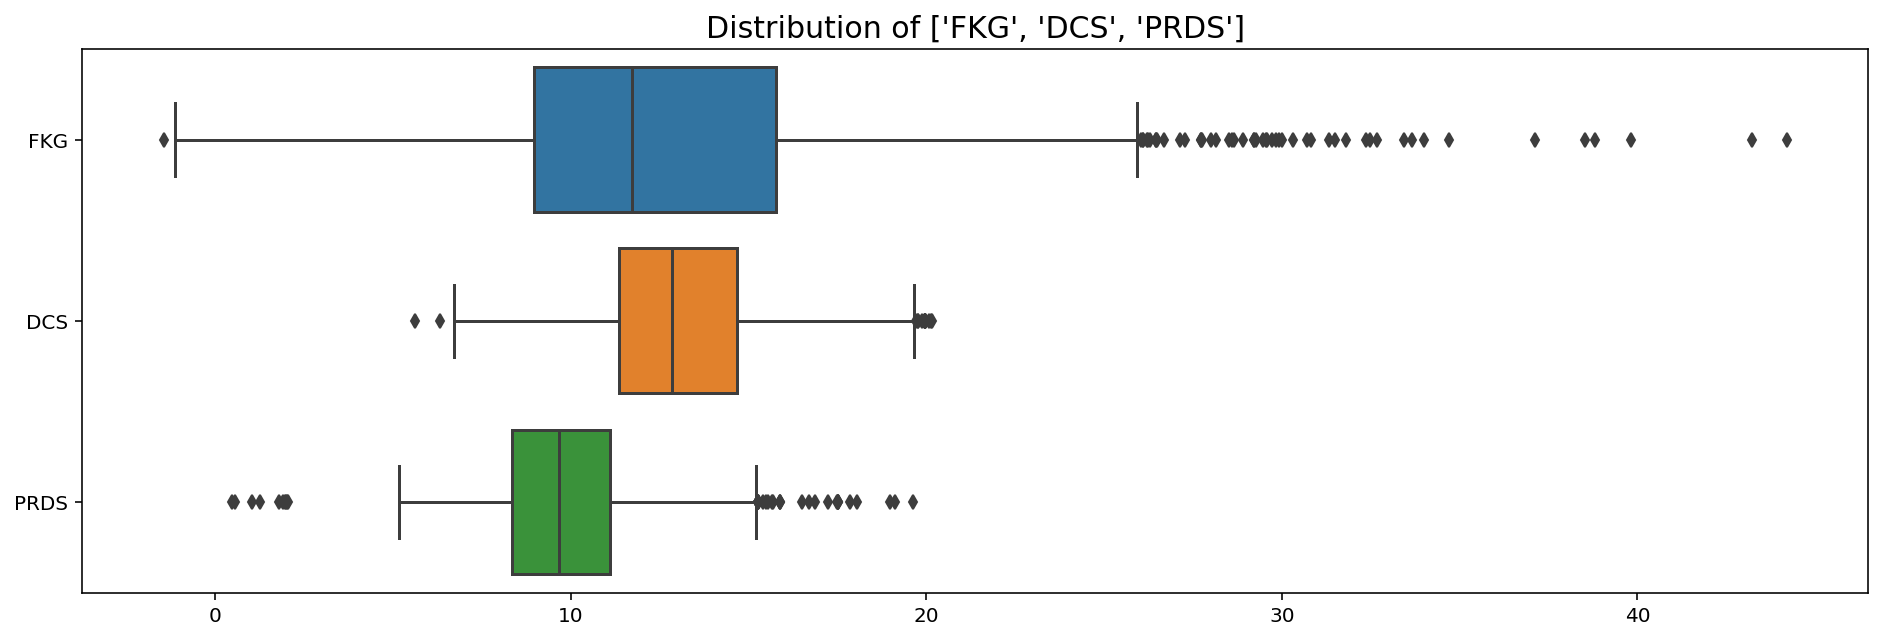

In [11]:
distribution_of_col(clean_df, ['FKG', 'DCS', 'PRDS'], 'fkg-dcs-prds-distribution.png')

In [12]:
# Scatterplot of closingTime and textLen
def jointplot_logx(_df: pd.DataFrame, col1: str, col2: str, fname: str = None):
    g = sns.jointplot(x=col1, y=col2, data=_df)
    g.ax_joint.set_xscale('log')
    g.ax_marg_x.set_xscale('log')
    g.annotate(stats.spearmanr)
    plt.title(f'Relationship between {col1} and {col2}', fontsize=20, loc='right', pad=80)
    if fname:
        plt.savefig(f'figures/{fname}', bbox_inches='tight')
    plt.show()

## Correlation closingTime and readability

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


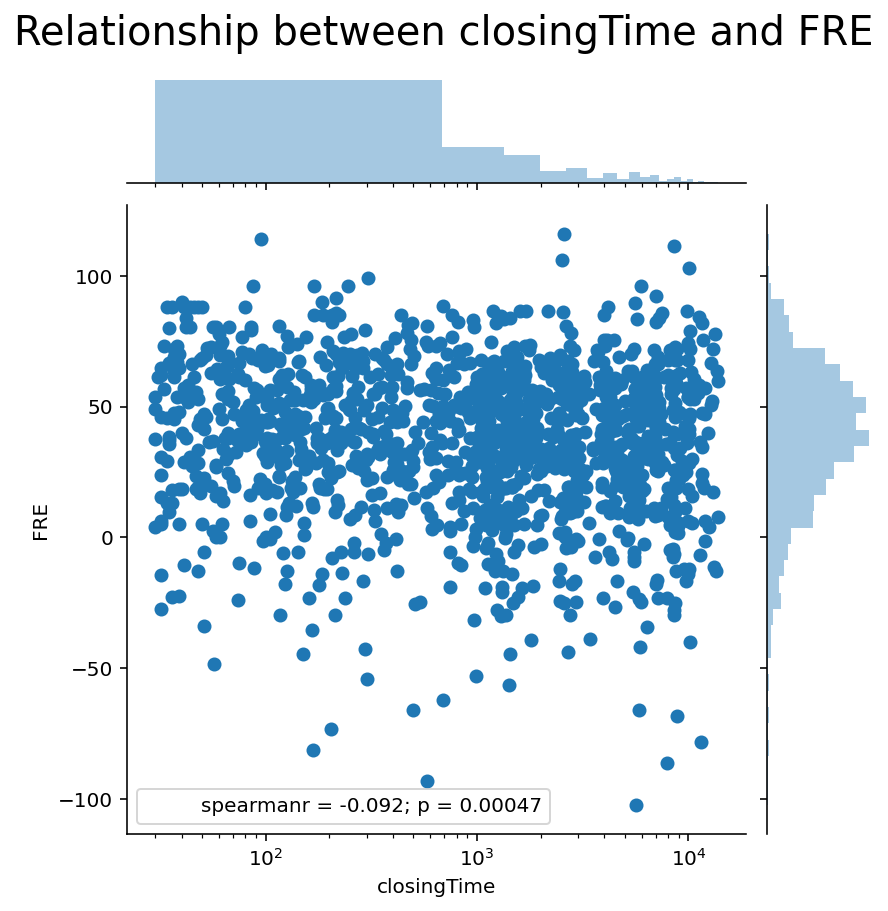

In [13]:
jointplot_logx(clean_df, 'closingTime', 'FRE', 'prs-closingtime-fre.png')

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


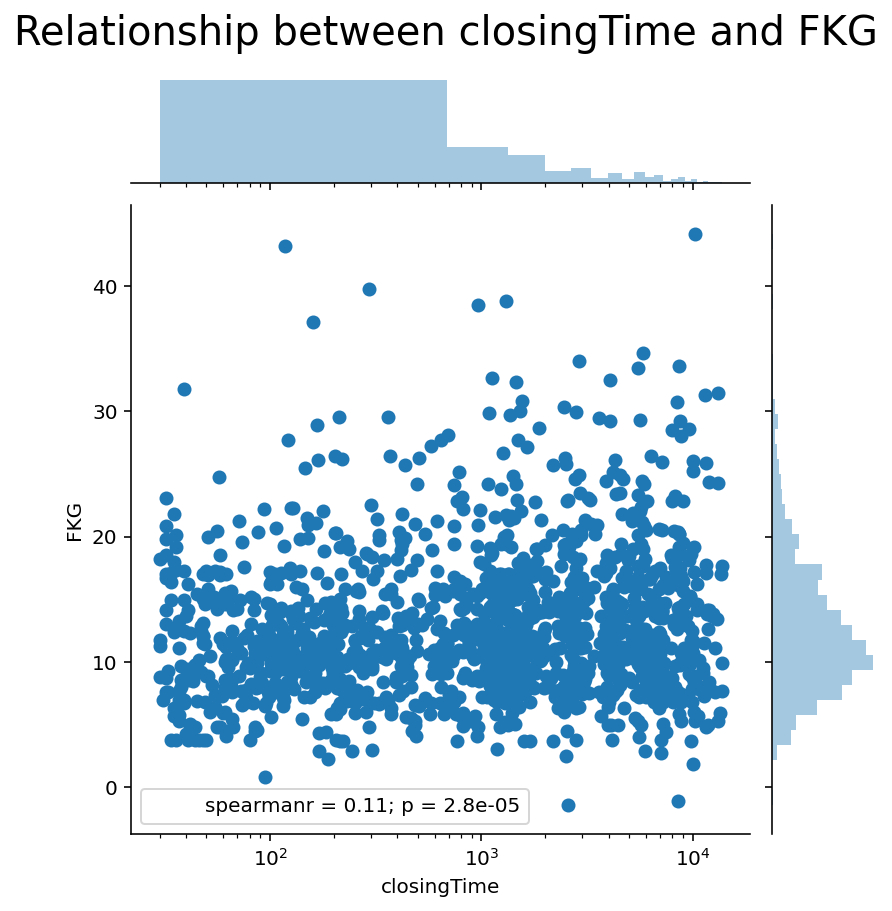

In [14]:
jointplot_logx(clean_df, 'closingTime', 'FKG', 'prs-closingtime-fkg.png')

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


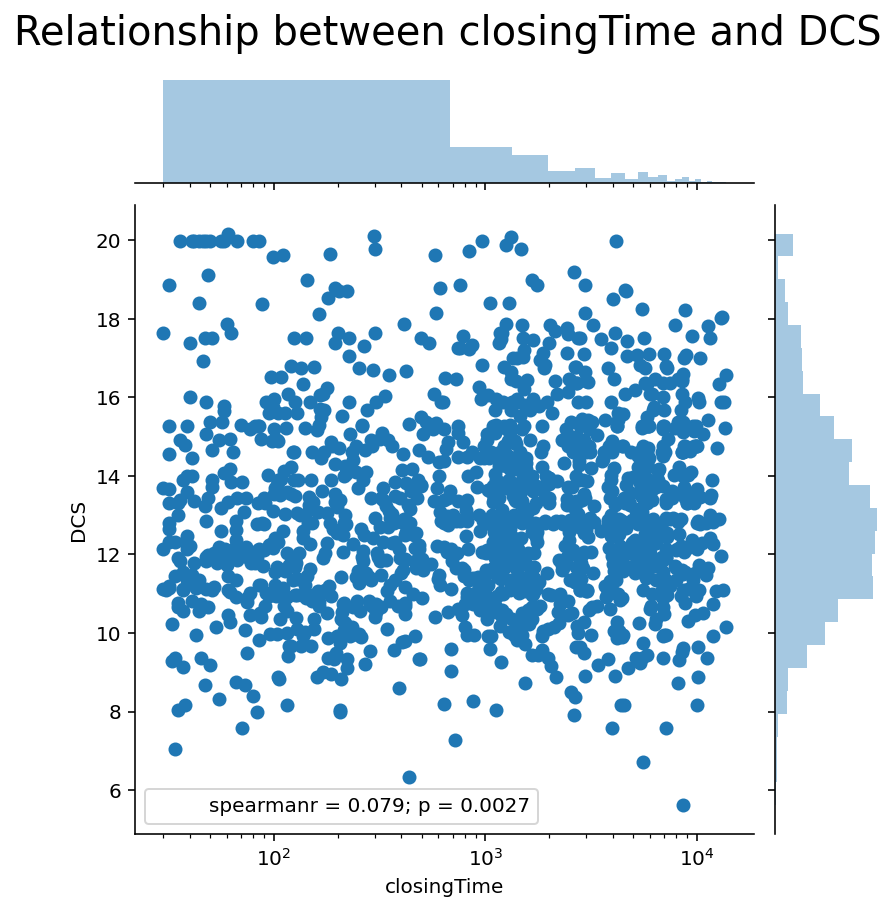

In [15]:
jointplot_logx(clean_df, 'closingTime', 'DCS', 'prs-closingtime-dcs.png')

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


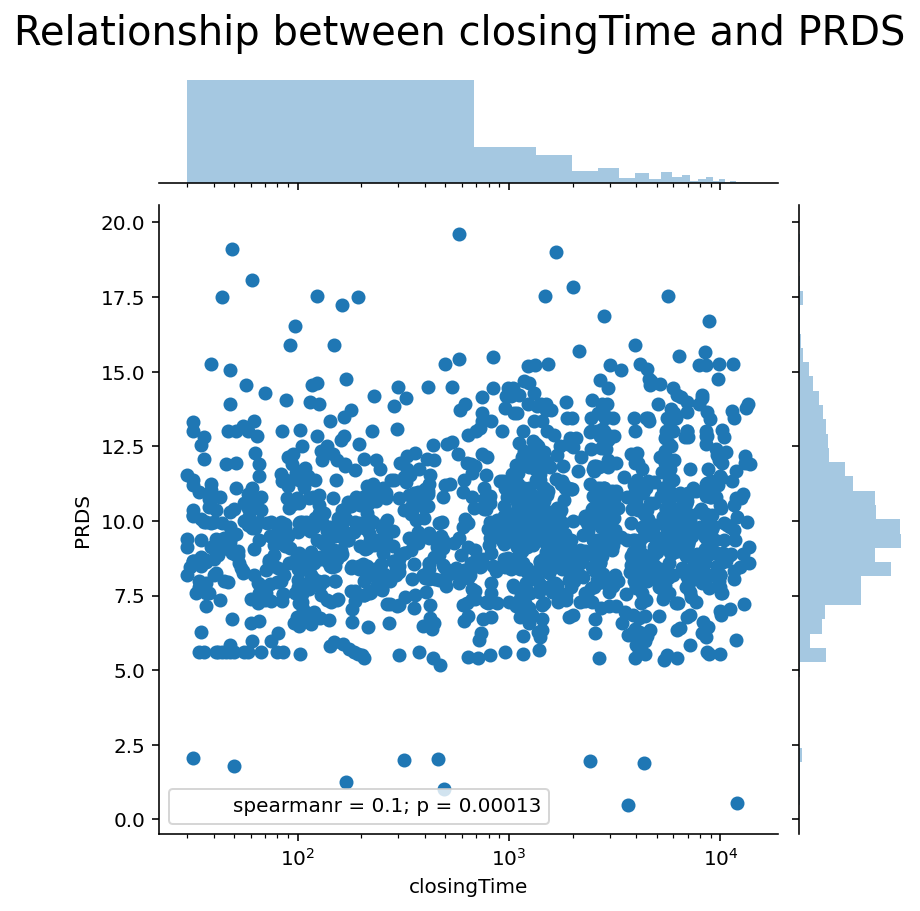

In [16]:
jointplot_logx(clean_df, 'closingTime', 'PRDS', 'prs-closingtime-prds.png')

## Correlation closingTime and textLen

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


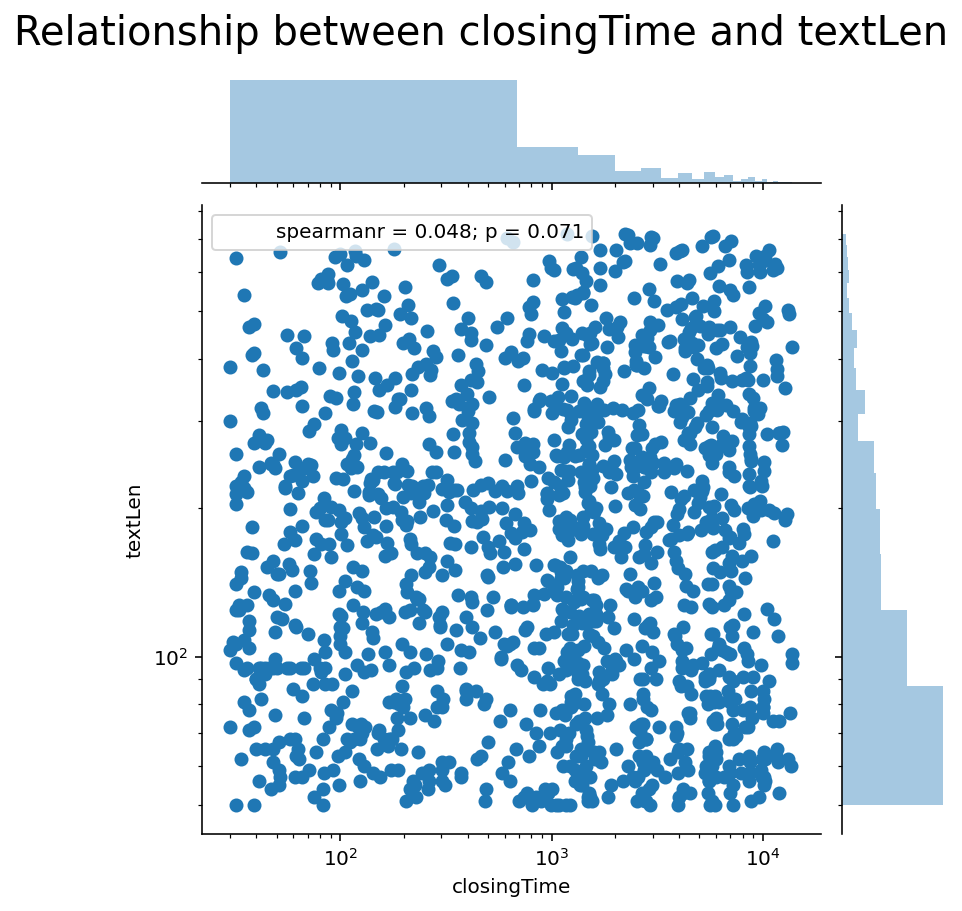

In [17]:
def jointplot_loglog(_df: pd.DataFrame, col1: str, col2: str, fname: str = None):
    g = sns.jointplot(x=col1, y=col2, data=_df)
    g.ax_joint.set_xscale('log')
    g.ax_joint.set_yscale('log')
    g.ax_marg_x.set_xscale('log')
    g.ax_marg_y.set_yscale('log')
    g.annotate(stats.spearmanr)
    plt.title(f'Relationship between {col1} and {col2}', fontsize=20, loc='right', pad=80)
    if fname:
        plt.savefig(f'figures/{fname}', bbox_inches='tight')
    plt.show()

jointplot_loglog(clean_df, 'closingTime', 'textLen')